In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def int_to_one_hot_tensor(x):
    return F.one_hot(torch.tensor(x), num_classes=10)

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=int_to_one_hot_tensor
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=int_to_one_hot_tensor
)

input_layer_size = len(training_data[0][0].squeeze().flatten())
g = torch.Generator().manual_seed(42)

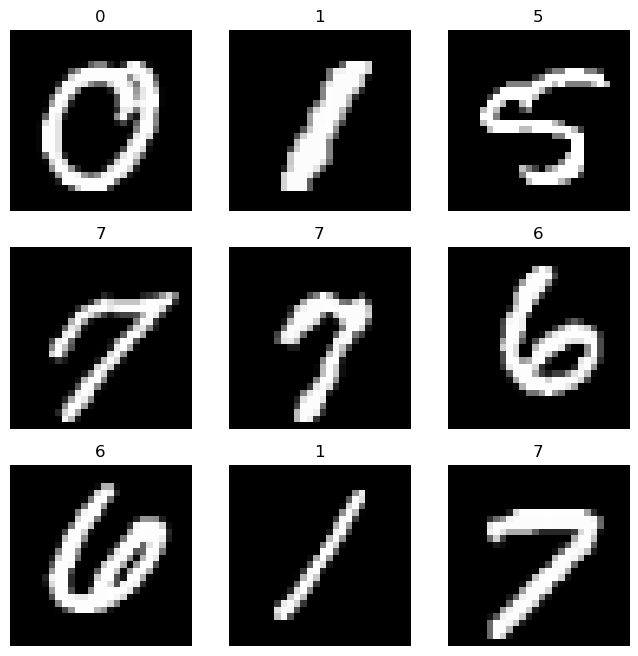

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(torch.argmax(label).item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
# network structure
hidden_layer_size = 32
number_of_digits = 10

L1 = torch.nn.Linear(input_layer_size, hidden_layer_size, bias=False) # Bias is part of next layer (batch norm)
BN1 = torch.nn.BatchNorm1d(hidden_layer_size)
L2 = torch.nn.Tanh()
L3 = torch.nn.Linear(hidden_layer_size, number_of_digits)

model = torch.nn.Sequential(L1, BN1, L2, L3)

In [5]:
# initialization
#nn.init.kaiming_normal_(L1, mode='fan_out', nonlinearity='relu')
torch.nn.init.ones_(BN1.weight)
torch.nn.init.zeros_(BN1.bias)
torch.nn.init.zeros_(L3.bias)
# ?? downscale L3.weights ?

# Dataloaders initialization / setting batch size
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# forward-pass
def forward_pass(features, model):
    X = features.squeeze().reshape(-1, input_layer_size)
    return model(X)

def calculate_accuracy_percent(logits, targets):
    softmax = torch.exp(F.log_softmax(logits, dim=1))
    return torch.mean(100 * (1 - torch.sum(targets * (1 - softmax), dim=1))).item()

In [7]:
# optimize
max_steps = 2000
stats_filter = max_steps / 20
stats_step = []
stats_acc = []
stats_loss = []

lr = 0.001

optim = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

for i in range(0, max_steps):
    train_features, train_labels = next(iter(train_dataloader))
    
    output = forward_pass(train_features, model)
    loss = loss_fn(output, train_labels.float())
    optim.zero_grad()
    loss.backward()
    optim.step()

    # stats
    if i % stats_filter == 0:
        stats_step.append(i)
        stats_loss.append(loss.item())
        stats_acc.append(calculate_accuracy_percent(output, train_labels))
        # TODO: add distribution stats
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

      0/   2000: 2.3680
    100/   2000: 0.7968
    200/   2000: 0.3599
    300/   2000: 0.4295
    400/   2000: 0.3092
    500/   2000: 0.2956
    600/   2000: 0.3136
    700/   2000: 0.2771
    800/   2000: 0.4548
    900/   2000: 0.2902
   1000/   2000: 0.1268
   1100/   2000: 0.2160
   1200/   2000: 0.3165
   1300/   2000: 0.1921
   1400/   2000: 0.2016
   1500/   2000: 0.1827
   1600/   2000: 0.2326
   1700/   2000: 0.5141
   1800/   2000: 0.1641
   1900/   2000: 0.2073


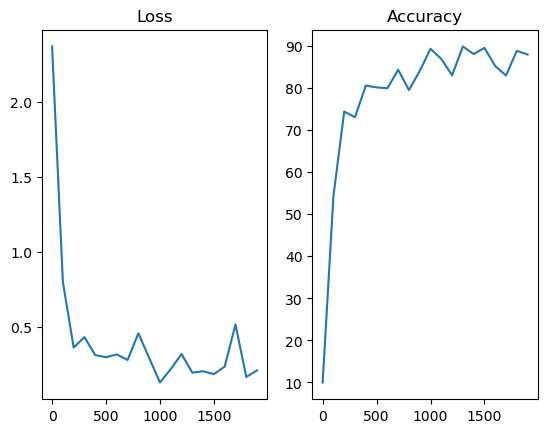

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Loss")
ax1.plot(stats_step, stats_loss)
ax2.set_title("Accuracy")
ax2.plot(stats_step, stats_acc)

plt.show()

In [9]:
test_max_steps = 100

stats_test_filter = test_max_steps / 10
stats_test_step = []
stats_test_acc = []
stats_test_loss = []

loss_fn = torch.nn.CrossEntropyLoss()

for i in range(0, test_max_steps):
    test_features, test_labels = next(iter(test_dataloader))
    
    output = forward_pass(test_features, model)
    loss = loss_fn(output, test_labels.float())
   
    # stats
    if i % stats_filter == 0:
        stats_test_loss.append(loss.item())
        stats_test_acc.append(calculate_accuracy_percent(output, test_labels))

print("loss: ", sum(stats_test_loss)/len(stats_test_loss))
print("acc: ", sum(stats_test_acc)/len(stats_test_acc))

loss:  0.16992130875587463
acc:  89.6433334350586


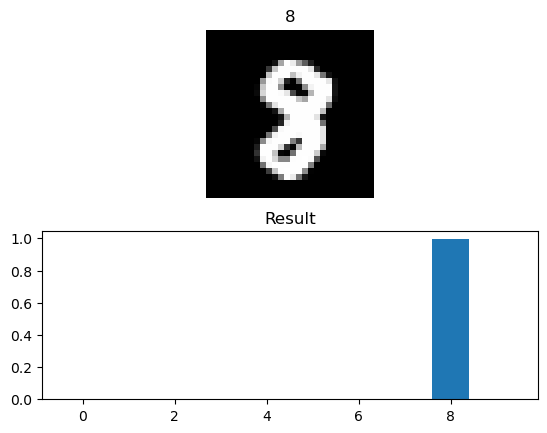

In [12]:
test_features, test_labels = next(iter(test_dataloader))
output = forward_pass(test_features, model)
softmax = [s.item() for s in torch.exp(F.log_softmax(output, dim=1)[0])]
img = test_features[0].squeeze()

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title(torch.argmax(test_labels[0]).item())
ax1.axis("off")
ax1.imshow(img, cmap="gray")
ax2.set_title("Result")
number_labels = range(0, 10)
ax2.bar(number_labels, softmax)
plt.show()